In [ ]:
import torch
import torch.nn as nn
import numpy as np
import math
import matplotlib.pyplot as plt

In [ ]:
class HedgingPolicy(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

        # IMPORTANT: zero initialization for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.zeros_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x).squeeze()

In [ ]:
def simulate_paths(S0, mu, sigma, T, N, M, device):
    dt = T / N
    S = torch.zeros(M, N + 1, device=device)
    S[:, 0] = S0

    for k in range(N):
        Z = torch.randn(M, device=device)
        S[:, k+1] = S[:, k] * torch.exp(
            (mu - 0.5 * sigma**2) * dt + sigma * math.sqrt(dt) * Z
        )

    return S

In [ ]:
def train(
    num_epochs=2000,
    batch_size=1024,
    S0=100.0,
    K=100.0,
    sigma=0.2,
    T=1.0,
    N=30,
    lambda_risk=1.0,
    lr=1e-4
):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    policy = HedgingPolicy().to(device)
    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

    loss_history = []

    # =====================
    # TRAINING LOOP
    # =====================
    for epoch in range(num_epochs):

        S = simulate_paths(
            S0=S0,
            mu=0.0,
            sigma=sigma,
            T=T,
            N=N,
            M=batch_size,
            device=device
        )

        trading_gain = torch.zeros(batch_size, device=device)

        for k in range(N):
            time = torch.full((batch_size,), k / N, device=device)
            state = torch.stack([S[:, k] / S0, time], dim=1)

            delta = policy(state)
            trading_gain += delta * (S[:, k+1] - S[:, k])

        payoff = torch.clamp(S[:, -1] - K, min=0.0)
        pnl = trading_gain - payoff

        # ---- scaled P&L ----
        pnl_scaled = pnl / pnl.std().detach()

        # ---- stable entropic loss ----
        loss = (
            torch.logsumexp(-lambda_risk * pnl_scaled, dim=0)
            - torch.log(torch.tensor(batch_size, device=device))
        )

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(policy.parameters(), 5.0)

        optimizer.step()

        loss_history.append(loss.item())

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss {loss.item():.4f}")

    return policy, loss_history

In [ ]:
policy, loss_history = train()

Epoch 0, Loss 1.7616
Epoch 100, Loss 1.6741
Epoch 200, Loss 2.0647
Epoch 300, Loss 1.6495
Epoch 400, Loss 1.7057
Epoch 500, Loss 1.7629
Epoch 600, Loss 1.8035
Epoch 700, Loss 1.7756
Epoch 800, Loss 1.8456
Epoch 900, Loss 1.8656
Epoch 1000, Loss 1.8630
Epoch 1100, Loss 1.9248
Epoch 1200, Loss 1.7316
Epoch 1300, Loss 1.7365
Epoch 1400, Loss 2.0902
Epoch 1500, Loss 1.8564
Epoch 1600, Loss 2.4725
Epoch 1700, Loss 2.0028
Epoch 1800, Loss 1.9371
Epoch 1900, Loss 2.2358


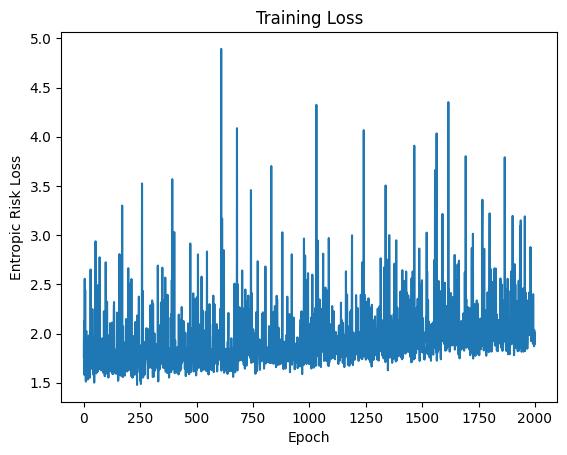

In [ ]:
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Entropic Risk Loss")
plt.title("Training Loss")
plt.show()

In [ ]:
# Re-simulate paths for evaluation
device = "cuda" if torch.cuda.is_available() else "cpu"
S_eval = simulate_paths(
    S0=100.0,
    mu=0.0,
    sigma=0.2,
    T=1.0,
    N=30,
    M=5000,
    device=device
)

trading_gain = torch.zeros(5000, device=device)

for k in range(30):
    time = torch.full((5000,), k / 30, device=device)
    state = torch.stack([S_eval[:, k] / 100.0, time], dim=1)
    with torch.no_grad():
        delta = policy(state)
    trading_gain += delta * (S_eval[:, k+1] - S_eval[:, k])

payoff = torch.clamp(S_eval[:, -1] - 100.0, min=0.0)
pnl_eval = trading_gain - payoff

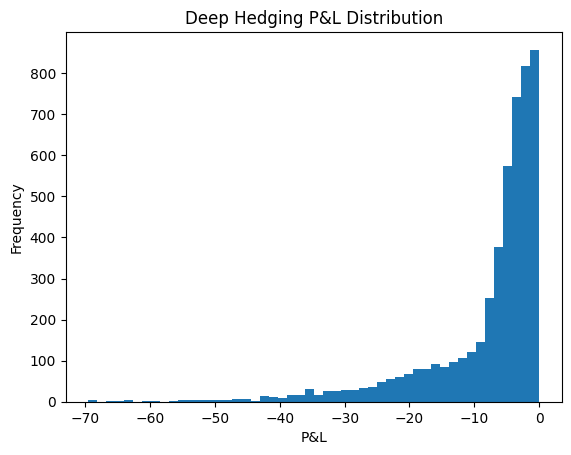

In [ ]:
plt.hist(pnl_eval.cpu().numpy(), bins=50)
plt.title("Deep Hedging P&L Distribution")
plt.xlabel("P&L")
plt.ylabel("Frequency")
plt.show()

In [ ]:
from scipy.stats import norm

def bs_delta_call(S, K, T, t, sigma, r=0.0):
    tau = T - t
    tau = np.maximum(tau, 1e-6)  # avoid division by zero

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    return norm.cdf(d1)

In [ ]:
S_np = S_eval.cpu().numpy()

delta_gain = np.zeros(S_np.shape[0])

for k in range(30):
    t = k / 30
    delta_bs = bs_delta_call(
        S=S_np[:, k],
        K=100.0,
        T=1.0,
        t=t,
        sigma=0.2
    )

    delta_gain += delta_bs * (S_np[:, k+1] - S_np[:, k])

payoff_np = np.maximum(S_np[:, -1] - 100.0, 0.0)
pnl_delta = delta_gain - payoff_np

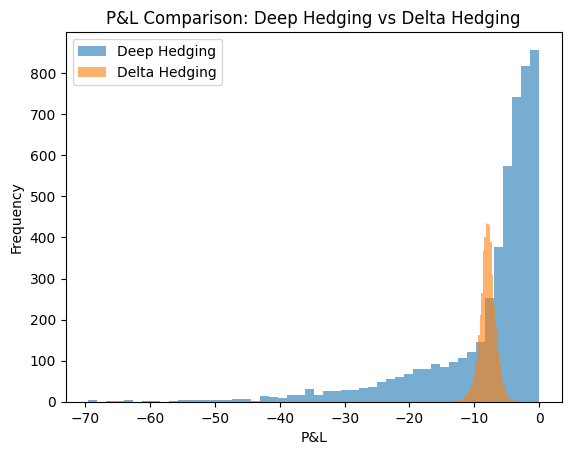

In [ ]:
plt.hist(pnl_eval.cpu().numpy(), bins=50, alpha=0.6, label="Deep Hedging")
plt.hist(pnl_delta, bins=50, alpha=0.6, label="Delta Hedging")
plt.xlabel("P&L")
plt.ylabel("Frequency")
plt.title("P&L Comparison: Deep Hedging vs Delta Hedging")
plt.legend()
plt.show()

In [ ]:
def risk_metrics(pnl):
    return {
        "Mean": np.mean(pnl),
        "Std": np.std(pnl),
        "5% Quantile": np.quantile(pnl, 0.05),
        "1% Quantile": np.quantile(pnl, 0.01)
    }

deep_metrics = risk_metrics(pnl_eval.cpu().numpy())
delta_metrics = risk_metrics(pnl_delta)

print("Deep Hedging Risk Metrics")
for k, v in deep_metrics.items():
    print(f"{k}: {v:.4f}")

print("\nDelta Hedging Risk Metrics")
for k, v in delta_metrics.items():
    print(f"{k}: {v:.4f}")

Deep Hedging Risk Metrics
Mean: -7.9456
Std: 9.5411
5% Quantile: -28.9950
1% Quantile: -43.0159

Delta Hedging Risk Metrics
Mean: -7.9534
Std: 1.2387
5% Quantile: -10.0361
1% Quantile: -11.4057


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Price grid
prices = torch.linspace(60, 140, 200, device=device)

# Fixed time (mid-maturity)
t_fixed = 0.5
time_tensor = torch.full((len(prices),), t_fixed, device=device)

# NN input state
state = torch.stack([prices / 100.0, time_tensor], dim=1)

In [ ]:
with torch.no_grad():
    nn_delta = policy(state).cpu().numpy()

In [ ]:
prices_np = prices.cpu().numpy()

bs_delta = bs_delta_call(
    S=prices_np,
    K=100.0,
    T=1.0,
    t=t_fixed,
    sigma=0.2
)

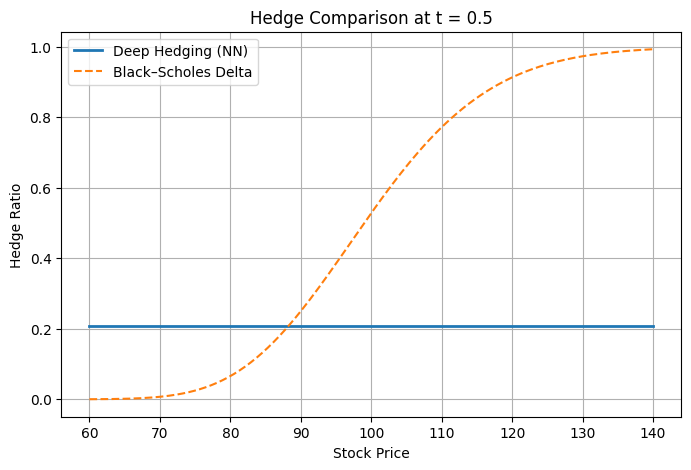

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(prices_np, nn_delta, label="Deep Hedging (NN)", linewidth=2)
plt.plot(prices_np, bs_delta, label="Black–Scholes Delta", linestyle="--")
plt.xlabel("Stock Price")
plt.ylabel("Hedge Ratio")
plt.title(f"Hedge Comparison at t = {t_fixed}")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def simulate_heston_paths(
    S0,
    v0,
    kappa,
    theta,
    xi,
    rho,
    T,
    N,
    M,
    device
):
    dt = T / N

    S = torch.zeros(M, N + 1, device=device)
    v = torch.zeros(M, N + 1, device=device)

    S[:, 0] = S0
    v[:, 0] = v0

    for k in range(N):
        Z1 = torch.randn(M, device=device)
        Z2 = torch.randn(M, device=device)

        # Correlated Brownian motions
        W1 = Z1
        W2 = rho * Z1 + torch.sqrt(torch.tensor(1 - rho**2, device=device)) * Z2

        v_prev = torch.clamp(v[:, k], min=0.0)

        # Variance process (full truncation)
        v[:, k+1] = torch.clamp(
            v_prev
            + kappa * (theta - v_prev) * dt
            + xi * torch.sqrt(v_prev * dt) * W2,
            min=0.0
        )

        # Stock price process
        S[:, k+1] = S[:, k] * torch.exp(
            -0.5 * v_prev * dt
            + torch.sqrt(v_prev * dt) * W1
        )

    return S, v

In [ ]:
def train_heston(
    num_epochs=2000,
    batch_size=1024,
    S0=100.0,
    K=100.0,
    v0=0.04,
    kappa=2.0,
    theta=0.04,
    xi=0.5,
    rho=-0.7,
    T=1.0,
    N=30,
    lambda_risk=1.0,
    lr=1e-4
):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    policy = HedgingPolicy().to(device)
    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

    loss_history = []

    for epoch in range(num_epochs):

        # ---- Heston paths ----
        S, v = simulate_heston_paths(
            S0=S0,
            v0=v0,
            kappa=kappa,
            theta=theta,
            xi=xi,
            rho=rho,
            T=T,
            N=N,
            M=batch_size,
            device=device
        )

        trading_gain = torch.zeros(batch_size, device=device)

        for k in range(N):
            time = torch.full((batch_size,), k / N, device=device)
            state = torch.stack([S[:, k] / S0, time], dim=1)

            delta = policy(state)
            trading_gain += delta * (S[:, k+1] - S[:, k])

        payoff = torch.clamp(S[:, -1] - K, min=0.0)
        pnl = trading_gain - payoff   # RAW P&L

        # ---- scale for numerical stability (NOT clipping) ----
        pnl_scaled = pnl / (pnl.std().detach() + 1e-8)

        # ---- entropic risk (log-sum-exp form) ----
        loss = (
            torch.logsumexp(-lambda_risk * pnl_scaled, dim=0)
            - torch.log(torch.tensor(batch_size, device=device))
        )

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(policy.parameters(), 5.0)
        optimizer.step()

        loss_history.append(loss.item())

        if epoch % 100 == 0:
            print(f"[Heston] Epoch {epoch}, Loss {loss.item():.4f}")

    return policy, loss_history

In [ ]:
policy_heston, loss_hist_heston = train_heston()

[Heston] Epoch 0, Loss 1.5754
[Heston] Epoch 100, Loss 1.5985
[Heston] Epoch 200, Loss 1.6402
[Heston] Epoch 300, Loss 1.6801
[Heston] Epoch 400, Loss 2.0198
[Heston] Epoch 500, Loss 1.5686
[Heston] Epoch 600, Loss 1.6251
[Heston] Epoch 700, Loss 1.6229
[Heston] Epoch 800, Loss 1.6764
[Heston] Epoch 900, Loss 1.7248
[Heston] Epoch 1000, Loss 1.7249
[Heston] Epoch 1100, Loss 1.8714
[Heston] Epoch 1200, Loss 1.7611
[Heston] Epoch 1300, Loss 1.9899
[Heston] Epoch 1400, Loss 1.7592
[Heston] Epoch 1500, Loss 1.8983
[Heston] Epoch 1600, Loss 1.9016
[Heston] Epoch 1700, Loss 1.9439
[Heston] Epoch 1800, Loss 1.7683
[Heston] Epoch 1900, Loss 1.9076


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

S_eval, v_eval = simulate_heston_paths(
    S0=100.0,
    v0=0.04,
    kappa=2.0,
    theta=0.04,
    xi=0.5,
    rho=-0.7,
    T=1.0,
    N=30,
    M=5000,
    device=device
)

In [ ]:
trading_gain = torch.zeros(5000, device=device)

for k in range(30):
    time = torch.full((5000,), k / 30, device=device)
    state = torch.stack([S_eval[:, k] / 100.0, time], dim=1)

    with torch.no_grad():
        delta = policy_heston(state)

    trading_gain += delta * (S_eval[:, k+1] - S_eval[:, k])

payoff = torch.clamp(S_eval[:, -1] - 100.0, min=0.0)
pnl_heston = trading_gain - payoff

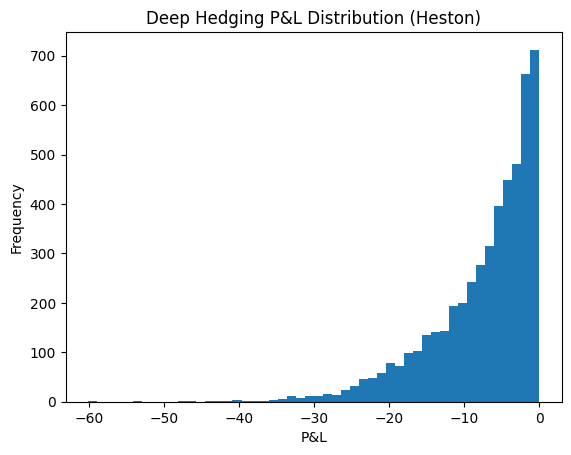

In [ ]:
plt.hist(pnl_heston.cpu().numpy(), bins=50)
plt.title("Deep Hedging P&L Distribution (Heston)")
plt.xlabel("P&L")
plt.ylabel("Frequency")
plt.show()

In [ ]:
pnl_heston_np = pnl_heston.cpu().numpy()

print("Deep Hedging (Heston)")
print("Mean:", pnl_heston_np.mean())
print("Std:", pnl_heston_np.std())
print("5% Quantile:", np.quantile(pnl_heston_np, 0.05))
print("1% Quantile:", np.quantile(pnl_heston_np, 0.01))

Deep Hedging (Heston)
Mean: -7.5161204
Std: 7.0175223
5% Quantile: -21.511995
1% Quantile: -30.64314


In [ ]:
S_np = S_eval.cpu().numpy()

delta_gain = np.zeros(S_np.shape[0])

for k in range(30):
    t = k / 30
    delta_bs = bs_delta_call(
        S=S_np[:, k],
        K=100.0,
        T=1.0,
        t=t,
        sigma=0.2   # fixed volatility
    )

    delta_gain += delta_bs * (S_np[:, k+1] - S_np[:, k])

payoff_np = np.maximum(S_np[:, -1] - 100.0, 0.0)
pnl_delta_heston = delta_gain - payoff_np

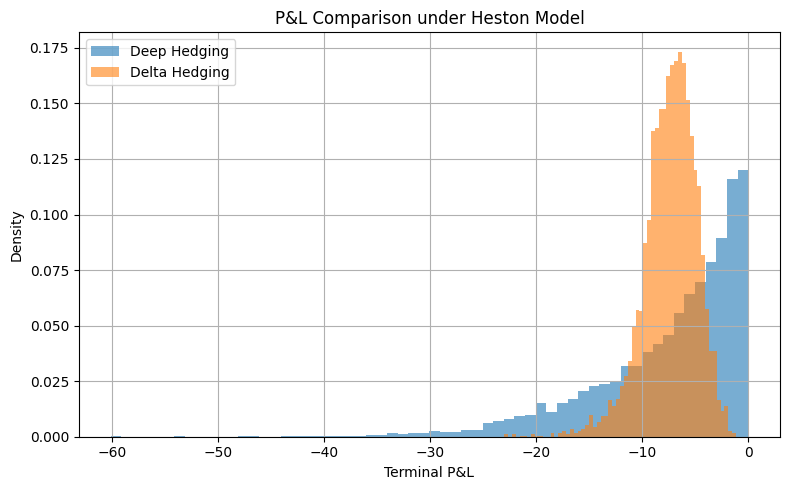

In [ ]:
plt.figure(figsize=(8, 5))

plt.hist(
    pnl_heston_np,
    bins=60,
    density=True,
    alpha=0.6,
    label="Deep Hedging"
)

plt.hist(
    pnl_delta_heston,
    bins=60,
    density=True,
    alpha=0.6,
    label="Delta Hedging"
)

plt.xlabel("Terminal P&L")
plt.ylabel("Density")
plt.title("P&L Comparison under Heston Model")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [ ]:
def risk_metrics(pnl):
    return {
        "Mean": np.mean(pnl),
        "Std": np.std(pnl),
        "5% Quantile": np.quantile(pnl, 0.05),
        "1% Quantile": np.quantile(pnl, 0.01)
    }

deep_metrics = risk_metrics(pnl_heston_np)
delta_metrics = risk_metrics(pnl_delta_heston)

print("Deep Hedging (Heston)")
for k, v in deep_metrics.items():
    print(f"{k}: {v:.4f}")

print("\nDelta Hedging (Heston)")
for k, v in delta_metrics.items():
    print(f"{k}: {v:.4f}")

Deep Hedging (Heston)
Mean: -7.5161
Std: 7.0175
5% Quantile: -21.5120
1% Quantile: -30.6431

Delta Hedging (Heston)
Mean: -7.3769
Std: 2.5282
5% Quantile: -11.7314
1% Quantile: -15.1015


In [ ]:
def train_heston_tc(
    num_epochs=2000,
    batch_size=1024,
    S0=100.0,
    K=100.0,
    v0=0.04,
    kappa=2.0,
    theta=0.04,
    xi=0.5,
    rho=-0.7,
    T=1.0,
    N=30,
    lambda_risk=1.0,
    tc_rate=0.001,   # proportional transaction cost
    lr=1e-4
):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    policy = HedgingPolicy().to(device)
    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

    loss_history = []

    for epoch in range(num_epochs):

        # ---- Heston paths ----
        S, v = simulate_heston_paths(
            S0=S0,
            v0=v0,
            kappa=kappa,
            theta=theta,
            xi=xi,
            rho=rho,
            T=T,
            N=N,
            M=batch_size,
            device=device
        )

        trading_gain = torch.zeros(batch_size, device=device)
        transaction_costs = torch.zeros(batch_size, device=device)

        prev_delta = torch.zeros(batch_size, device=device)

        for k in range(N):
            time = torch.full((batch_size,), k / N, device=device)
            state = torch.stack([S[:, k] / S0, time], dim=1)

            delta = policy(state)

            # ---- trading gains ----
            trading_gain += delta * (S[:, k+1] - S[:, k])

            # ---- proportional transaction costs ----
            transaction_costs += tc_rate * torch.abs(delta - prev_delta) * S[:, k]

            prev_delta = delta

        payoff = torch.clamp(S[:, -1] - K, min=0.0)

        # ---- RAW terminal P&L ----
        pnl = trading_gain - payoff - transaction_costs

        # ---- scale P&L for numerical stability ----
        pnl_scaled = pnl / (pnl.std().detach() + 1e-8)

        # ---- stable entropic risk (log-sum-exp) ----
        loss = (
            torch.logsumexp(-lambda_risk * pnl_scaled, dim=0)
            - torch.log(torch.tensor(batch_size, device=device))
        )

        optimizer.zero_grad()
        loss.backward()

        # ---- gradient clipping ----
        torch.nn.utils.clip_grad_norm_(policy.parameters(), 5.0)

        optimizer.step()

        loss_history.append(loss.item())

        if epoch % 100 == 0:
            print(f"[Heston + TC] Epoch {epoch}, Loss {loss.item():.4f}")

    return policy, loss_history

In [ ]:
policy_heston_tc, loss_tc = train_heston_tc()

[Heston + TC] Epoch 0, Loss 1.5690
[Heston + TC] Epoch 100, Loss 1.7514
[Heston + TC] Epoch 200, Loss 2.0834
[Heston + TC] Epoch 300, Loss 1.6428
[Heston + TC] Epoch 400, Loss 1.6843
[Heston + TC] Epoch 500, Loss 1.9146
[Heston + TC] Epoch 600, Loss 1.6401
[Heston + TC] Epoch 700, Loss 1.6711
[Heston + TC] Epoch 800, Loss 1.6728
[Heston + TC] Epoch 900, Loss 1.9161
[Heston + TC] Epoch 1000, Loss 1.7294
[Heston + TC] Epoch 1100, Loss 1.9918
[Heston + TC] Epoch 1200, Loss 1.7916
[Heston + TC] Epoch 1300, Loss 1.7415
[Heston + TC] Epoch 1400, Loss 1.8389
[Heston + TC] Epoch 1500, Loss 1.8067
[Heston + TC] Epoch 1600, Loss 1.8488
[Heston + TC] Epoch 1700, Loss 1.7790
[Heston + TC] Epoch 1800, Loss 1.9562
[Heston + TC] Epoch 1900, Loss 1.9427


In [ ]:
S_eval, _ = simulate_heston_paths(
    S0=100.0,
    v0=0.04,
    kappa=2.0,
    theta=0.04,
    xi=0.5,
    rho=-0.7,
    T=1.0,
    N=30,
    M=5000,
    device=device
)

trading_gain = torch.zeros(5000, device=device)
prev_delta = torch.zeros(5000, device=device)

for k in range(30):
    time = torch.full((5000,), k / 30, device=device)
    state = torch.stack([S_eval[:, k] / 100.0, time], dim=1)

    with torch.no_grad():
        delta = policy_heston_tc(state)

    trading_gain += delta * (S_eval[:, k+1] - S_eval[:, k])
    trading_gain -= 0.001 * S_eval[:, k] * torch.abs(delta - prev_delta)

    prev_delta = delta

payoff = torch.clamp(S_eval[:, -1] - 100.0, min=0.0)
pnl_heston_tc = trading_gain - payoff

In [ ]:
pnl_tc_np = pnl_heston_tc.cpu().numpy()

print("Deep Hedging (Heston + Transaction Costs)")
print("Mean:", pnl_tc_np.mean())
print("Std:", pnl_tc_np.std())
print("5% Quantile:", np.quantile(pnl_tc_np, 0.05))
print("1% Quantile:", np.quantile(pnl_tc_np, 0.01))

Deep Hedging (Heston + Transaction Costs)
Mean: -7.330558
Std: 6.907832
5% Quantile: -21.191706
1% Quantile: -30.492516


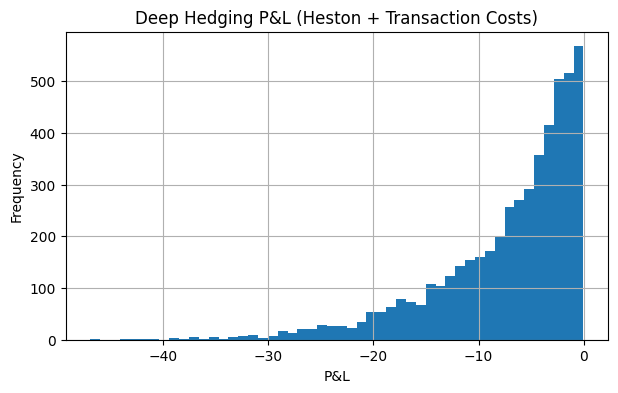

In [ ]:
plt.figure(figsize=(7,4))
plt.hist(pnl_heston_tc.cpu().numpy(), bins=50)
plt.title("Deep Hedging P&L (Heston + Transaction Costs)")
plt.xlabel("P&L")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
S_np = S_eval.cpu().numpy()

delta_gain = np.zeros(S_np.shape[0])
prev_delta = np.zeros(S_np.shape[0])

for k in range(30):
    t = k / 30

    delta_bs = bs_delta_call(
        S=S_np[:, k],
        K=100.0,
        T=1.0,
        t=t,
        sigma=0.2
    )

    # Trading gain
    delta_gain += delta_bs * (S_np[:, k+1] - S_np[:, k])

    # Transaction cost
    delta_gain -= 0.001 * S_np[:, k] * np.abs(delta_bs - prev_delta)

    prev_delta = delta_bs

payoff_np = np.maximum(S_np[:, -1] - 100.0, 0.0)
pnl_delta_tc = delta_gain - payoff_np

In [ ]:
print("Deep Hedging (Heston + TC)")
print("Mean:", pnl_tc_np.mean())
print("Std:", pnl_tc_np.std())
print("5% Quantile:", np.quantile(pnl_tc_np, 0.05))
print("1% Quantile:", np.quantile(pnl_tc_np, 0.01))

print("\nDelta Hedging (Heston + TC)")
print("Mean:", pnl_delta_tc.mean())
print("Std:", pnl_delta_tc.std())
print("5% Quantile:", np.quantile(pnl_delta_tc, 0.05))
print("1% Quantile:", np.quantile(pnl_delta_tc, 0.01))

Deep Hedging (Heston + TC)
Mean: -7.330558
Std: 6.907832
5% Quantile: -21.191706
1% Quantile: -30.492516

Delta Hedging (Heston + TC)
Mean: -7.592568495367519
Std: 2.636436553373772
5% Quantile: -12.07841639580913
1% Quantile: -15.661438924986356


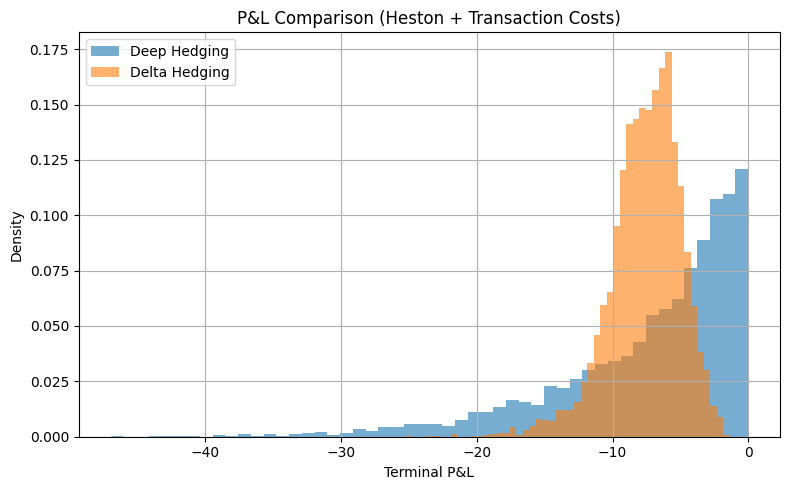

In [ ]:
plt.figure(figsize=(8, 5))

plt.hist(
    pnl_heston_tc.cpu().numpy(),
    bins=50,
    density=True,
    alpha=0.6,
    label="Deep Hedging"
)

plt.hist(
    pnl_delta_tc,
    bins=50,
    density=True,
    alpha=0.6,
    label="Delta Hedging"
)

plt.xlabel("Terminal P&L")
plt.ylabel("Density")
plt.title("P&L Comparison (Heston + Transaction Costs)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
lambda_risk = 1.0
CE_deep = -np.log(np.mean(np.exp(-lambda_risk * pnl_tc_np))) / lambda_risk
CE_delta = -np.log(np.mean(np.exp(-lambda_risk * pnl_delta_tc))) / lambda_risk

print("Certainty Equivalent (Deep Hedging):", CE_deep)
print("Certainty Equivalent (Delta Hedging):", CE_delta)

Certainty Equivalent (Deep Hedging): -38.515102
Certainty Equivalent (Delta Hedging): -17.00141006755992


In [ ]:
def train(
    lambda_risk,
    num_epochs=2000,
    batch_size=1024,
    S0=100.0,
    K=100.0,
    sigma=0.2,
    T=1.0,
    N=30,
    lr=1e-4,
):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    policy = HedgingPolicy().to(device)
    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

    loss_history = []

    # =====================
    # TRAINING LOOP
    # =====================
    for epoch in range(num_epochs):

        # ---- simulate GBM paths ----
        S = simulate_paths(
            S0=S0,
            mu=0.0,
            sigma=sigma,
            T=T,
            N=N,
            M=batch_size,
            device=device
        )

        trading_gain = torch.zeros(batch_size, device=device)

        # ---- dynamic hedging ----
        for k in range(N):
            time = torch.full((batch_size,), k / N, device=device)
            state = torch.stack([S[:, k] / S0, time], dim=1)

            delta = policy(state)
            trading_gain += delta * (S[:, k+1] - S[:, k])

        payoff = torch.clamp(S[:, -1] - K, min=0.0)

        # ---- RAW terminal P&L ----
        pnl = trading_gain - payoff

        # ---- scale P&L for numerical stability (training only) ----
        pnl_scaled = pnl / (pnl.std().detach() + 1e-8)

        # ---- stable entropic risk objective ----
        loss = (
            torch.logsumexp(-lambda_risk * pnl_scaled, dim=0)
            - torch.log(torch.tensor(batch_size, device=device))
        )

        optimizer.zero_grad()
        loss.backward()

        # ---- gradient clipping ----
        torch.nn.utils.clip_grad_norm_(policy.parameters(), 5.0)

        optimizer.step()

        loss_history.append(loss.item())

        if epoch % 100 == 0:
            print(f"[BS] Epoch {epoch}, Loss {loss.item():.4f}")

    # =====================
    # EVALUATION (NO TRAINING)
    # =====================
    with torch.no_grad():

        S = simulate_paths(
            S0=S0,
            mu=0.0,
            sigma=sigma,
            T=T,
            N=N,
            M=batch_size,
            device=device
        )

        trading_gain = torch.zeros(batch_size, device=device)

        for k in range(N):
            time = torch.full((batch_size,), k / N, device=device)
            state = torch.stack([S[:, k] / S0, time], dim=1)

            delta = policy(state)
            trading_gain += delta * (S[:, k+1] - S[:, k])

        payoff = torch.clamp(S[:, -1] - K, min=0.0)

        # ---- FINAL ECONOMIC P&L (no scaling, no clipping) ----
        pnl_eval = trading_gain - payoff

    return policy, pnl_eval

In [ ]:
def train_heston(
    lambda_risk,
    num_epochs=2000,
    batch_size=1024,
    S0=100.0,
    K=100.0,
    T=1.0,
    N=30,
    lr=1e-4,
    v0=0.04,
    kappa=1.5,
    theta=0.04,
    xi=0.3,
    rho=-0.7,
):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    policy = HedgingPolicy().to(device)
    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

    loss_history = []

    # =====================
    # TRAINING LOOP
    # =====================
    for epoch in range(num_epochs):

        # ---- simulate Heston paths ----
        S, _ = simulate_heston_paths(
            S0=S0,
            v0=v0,
            kappa=kappa,
            theta=theta,
            xi=xi,
            rho=rho,
            T=T,
            N=N,
            M=batch_size,
            device=device
        )

        trading_gain = torch.zeros(batch_size, device=device)

        # ---- dynamic hedging ----
        for k in range(N):
            time = torch.full((batch_size,), k / N, device=device)
            state = torch.stack([S[:, k] / S0, time], dim=1)

            delta = policy(state)
            trading_gain += delta * (S[:, k+1] - S[:, k])

        payoff = torch.clamp(S[:, -1] - K, min=0.0)

        # ---- RAW terminal P&L ----
        pnl = trading_gain - payoff

        # ---- scale P&L (training only) ----
        pnl_scaled = pnl / (pnl.std().detach() + 1e-8)

        # ---- stable entropic risk objective ----
        loss = (
            torch.logsumexp(-lambda_risk * pnl_scaled, dim=0)
            - torch.log(torch.tensor(batch_size, device=device))
        )

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(policy.parameters(), 5.0)

        optimizer.step()

        loss_history.append(loss.item())

        if epoch % 100 == 0:
            print(f"[Heston] Epoch {epoch}, Loss {loss.item():.4f}")

    # =====================
    # EVALUATION (NO TRAINING)
    # =====================
    with torch.no_grad():

        S, _ = simulate_heston_paths(
            S0=S0,
            v0=v0,
            kappa=kappa,
            theta=theta,
            xi=xi,
            rho=rho,
            T=T,
            N=N,
            M=batch_size,
            device=device
        )

        trading_gain = torch.zeros(batch_size, device=device)

        for k in range(N):
            time = torch.full((batch_size,), k / N, device=device)
            state = torch.stack([S[:, k] / S0, time], dim=1)

            delta = policy(state)
            trading_gain += delta * (S[:, k+1] - S[:, k])

        payoff = torch.clamp(S[:, -1] - K, min=0.0)

        # ---- FINAL ECONOMIC P&L ----
        pnl_eval = trading_gain - payoff

    return policy, pnl_eval

In [ ]:
def train_heston_tc(
    lambda_risk,
    num_epochs=2000,
    batch_size=1024,
    S0=100.0,
    K=100.0,
    T=1.0,
    N=30,
    lr=1e-4,
    v0=0.04,
    kappa=1.5,
    theta=0.04,
    xi=0.3,
    rho=-0.7,
    tc=0.001,          # proportional transaction cost
):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    policy = HedgingPolicy().to(device)
    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

    loss_history = []

    # =====================
    # TRAINING LOOP
    # =====================
    for epoch in range(num_epochs):

        # ---- simulate Heston paths ----
        S, _ = simulate_heston_paths(
            S0=S0,
            v0=v0,
            kappa=kappa,
            theta=theta,
            xi=xi,
            rho=rho,
            T=T,
            N=N,
            M=batch_size,
            device=device
        )

        trading_gain = torch.zeros(batch_size, device=device)
        prev_delta = torch.zeros(batch_size, device=device)

        # ---- dynamic hedging with transaction costs ----
        for k in range(N):
            time = torch.full((batch_size,), k / N, device=device)
            state = torch.stack([S[:, k] / S0, time], dim=1)

            delta = policy(state)

            # trading P&L
            trading_gain += delta * (S[:, k+1] - S[:, k])

            # transaction costs
            trading_gain -= tc * torch.abs(delta - prev_delta) * S[:, k]

            prev_delta = delta

        payoff = torch.clamp(S[:, -1] - K, min=0.0)

        # ---- RAW terminal P&L ----
        pnl = trading_gain - payoff

        # ---- scale P&L (training only) ----
        pnl_scaled = pnl / (pnl.std().detach() + 1e-8)

        # ---- stable entropic risk objective ----
        loss = (
            torch.logsumexp(-lambda_risk * pnl_scaled, dim=0)
            - torch.log(torch.tensor(batch_size, device=device))
        )

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(policy.parameters(), 5.0)

        optimizer.step()

        loss_history.append(loss.item())

        if epoch % 100 == 0:
            print(f"[Heston + TC] Epoch {epoch}, Loss {loss.item():.4f}")

    # =====================
    # EVALUATION (NO TRAINING)
    # =====================
    with torch.no_grad():

        S, _ = simulate_heston_paths(
            S0=S0,
            v0=v0,
            kappa=kappa,
            theta=theta,
            xi=xi,
            rho=rho,
            T=T,
            N=N,
            M=batch_size,
            device=device
        )

        trading_gain = torch.zeros(batch_size, device=device)
        prev_delta = torch.zeros(batch_size, device=device)

        for k in range(N):
            time = torch.full((batch_size,), k / N, device=device)
            state = torch.stack([S[:, k] / S0, time], dim=1)

            delta = policy(state)

            trading_gain += delta * (S[:, k+1] - S[:, k])
            trading_gain -= tc * torch.abs(delta - prev_delta) * S[:, k]

            prev_delta = delta

        payoff = torch.clamp(S[:, -1] - K, min=0.0)

        # ---- FINAL ECONOMIC P&L ----
        pnl_eval = trading_gain - payoff

    return policy, pnl_eval

In [ ]:
lambda_grid = [0.1, 0.5, 1.0, 2.0]

results = {}
pnl_samples = {}

for lam in lambda_grid:
    print(f"Training for lambda = {lam}")

    policy, pnl = train(lambda_risk=lam)

    pnl_samples[lam] = pnl.detach().cpu().numpy()

    results[lam] = {
        "mean": pnl.mean().item(),
        "std": pnl.std().item(),
        "q05": torch.quantile(pnl, 0.05).item(),
        "ce": (-1 / lam) * torch.log(torch.mean(torch.exp(-lam * pnl))).item()
    }

Training for lambda = 0.1
[BS] Epoch 0, Loss 0.0651
[BS] Epoch 100, Loss 0.0652
[BS] Epoch 200, Loss 0.0660
[BS] Epoch 300, Loss 0.0700
[BS] Epoch 400, Loss 0.0703
[BS] Epoch 500, Loss 0.0697
[BS] Epoch 600, Loss 0.0704
[BS] Epoch 700, Loss 0.0714
[BS] Epoch 800, Loss 0.0706
[BS] Epoch 900, Loss 0.0725
[BS] Epoch 1000, Loss 0.0790
[BS] Epoch 1100, Loss 0.0764
[BS] Epoch 1200, Loss 0.0754
[BS] Epoch 1300, Loss 0.0768
[BS] Epoch 1400, Loss 0.0810
[BS] Epoch 1500, Loss 0.0823
[BS] Epoch 1600, Loss 0.0830
[BS] Epoch 1700, Loss 0.0853
[BS] Epoch 1800, Loss 0.0864
[BS] Epoch 1900, Loss 0.0873
Training for lambda = 0.5
[BS] Epoch 0, Loss 0.4928
[BS] Epoch 100, Loss 0.4932
[BS] Epoch 200, Loss 0.5103
[BS] Epoch 300, Loss 0.5066
[BS] Epoch 400, Loss 0.5053
[BS] Epoch 500, Loss 0.5096
[BS] Epoch 600, Loss 0.5261
[BS] Epoch 700, Loss 0.5251
[BS] Epoch 800, Loss 0.5229
[BS] Epoch 900, Loss 0.5349
[BS] Epoch 1000, Loss 0.5310
[BS] Epoch 1100, Loss 0.5418
[BS] Epoch 1200, Loss 0.5492
[BS] Epoch 1300

In [ ]:
lambda_grid = [0.1, 0.5, 1.0, 2.0]

results_heston = {}
pnl_samples_heston = {}

for lam in lambda_grid:
    print(f"\nTraining Heston (no TC) for lambda = {lam}")

    policy, pnl = train_heston(lambda_risk=lam)

    pnl_samples_heston[lam] = pnl.detach().cpu().numpy()

    results_heston[lam] = {
        "mean": pnl.mean().item(),
        "std": pnl.std().item(),
        "q05": torch.quantile(pnl, 0.05).item(),
        "ce": (-1 / lam) * torch.log(torch.mean(torch.exp(-lam * pnl))).item()
    }


Training Heston (no TC) for lambda = 0.1
[Heston] Epoch 0, Loss 0.0760
[Heston] Epoch 100, Loss 0.0814
[Heston] Epoch 200, Loss 0.0825
[Heston] Epoch 300, Loss 0.0812
[Heston] Epoch 400, Loss 0.0833
[Heston] Epoch 500, Loss 0.0857
[Heston] Epoch 600, Loss 0.0837
[Heston] Epoch 700, Loss 0.0869
[Heston] Epoch 800, Loss 0.0876
[Heston] Epoch 900, Loss 0.0900
[Heston] Epoch 1000, Loss 0.0910
[Heston] Epoch 1100, Loss 0.0918
[Heston] Epoch 1200, Loss 0.0901
[Heston] Epoch 1300, Loss 0.0936
[Heston] Epoch 1400, Loss 0.0955
[Heston] Epoch 1500, Loss 0.0973
[Heston] Epoch 1600, Loss 0.1009
[Heston] Epoch 1700, Loss 0.0976
[Heston] Epoch 1800, Loss 0.1003
[Heston] Epoch 1900, Loss 0.1040

Training Heston (no TC) for lambda = 0.5
[Heston] Epoch 0, Loss 0.5124
[Heston] Epoch 100, Loss 0.5385
[Heston] Epoch 200, Loss 0.5284
[Heston] Epoch 300, Loss 0.5498
[Heston] Epoch 400, Loss 0.5442
[Heston] Epoch 500, Loss 0.5461
[Heston] Epoch 600, Loss 0.5711
[Heston] Epoch 700, Loss 0.5633
[Heston] Epoch

In [ ]:
lambda_grid = [0.1, 0.5, 1.0, 2.0]

results_heston_tc = {}
pnl_samples_heston_tc = {}

for lam in lambda_grid:
    print(f"\nTraining Heston + TC for lambda = {lam}")

    policy, pnl = train_heston_tc(lambda_risk=lam)

    pnl_samples_heston_tc[lam] = pnl.detach().cpu().numpy()

    results_heston_tc[lam] = {
        "mean": pnl.mean().item(),
        "std": pnl.std().item(),
        "q05": torch.quantile(pnl, 0.05).item(),
        "ce": (-1 / lam) * torch.log(torch.mean(torch.exp(-lam * pnl))).item()
    }


Training Heston + TC for lambda = 0.1
[Heston + TC] Epoch 0, Loss 0.0795
[Heston + TC] Epoch 100, Loss 0.0777
[Heston + TC] Epoch 200, Loss 0.0823
[Heston + TC] Epoch 300, Loss 0.0826
[Heston + TC] Epoch 400, Loss 0.0805
[Heston + TC] Epoch 500, Loss 0.0826
[Heston + TC] Epoch 600, Loss 0.0837
[Heston + TC] Epoch 700, Loss 0.0889
[Heston + TC] Epoch 800, Loss 0.0882
[Heston + TC] Epoch 900, Loss 0.0900
[Heston + TC] Epoch 1000, Loss 0.0881
[Heston + TC] Epoch 1100, Loss 0.0933
[Heston + TC] Epoch 1200, Loss 0.0963
[Heston + TC] Epoch 1300, Loss 0.0959
[Heston + TC] Epoch 1400, Loss 0.0976
[Heston + TC] Epoch 1500, Loss 0.0969
[Heston + TC] Epoch 1600, Loss 0.1003
[Heston + TC] Epoch 1700, Loss 0.1008
[Heston + TC] Epoch 1800, Loss 0.0997
[Heston + TC] Epoch 1900, Loss 0.1011

Training Heston + TC for lambda = 0.5
[Heston + TC] Epoch 0, Loss 0.5438
[Heston + TC] Epoch 100, Loss 0.5229
[Heston + TC] Epoch 200, Loss 0.5277
[Heston + TC] Epoch 300, Loss 0.5433
[Heston + TC] Epoch 400, Los

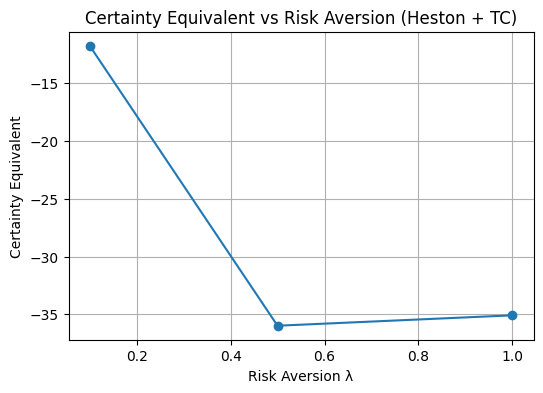

In [ ]:
lams = sorted(results_heston_tc.keys())
ce_vals = [results_heston_tc[lam]["ce"] for lam in lams]

plt.figure(figsize=(6,4))
plt.plot(lams, ce_vals, marker="o")
plt.xlabel("Risk Aversion λ")
plt.ylabel("Certainty Equivalent")
plt.title("Certainty Equivalent vs Risk Aversion (Heston + TC)")
plt.grid(True)
plt.show()

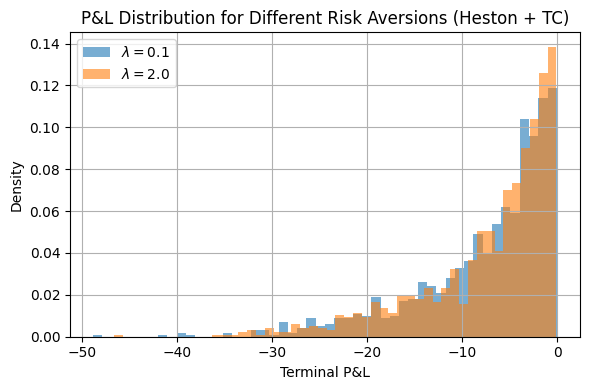

In [ ]:
plt.figure(figsize=(6,4))

plt.hist(
    pnl_samples_heston_tc[0.1],
    bins=50,
    density=True,
    alpha=0.6,
    label=r"$\lambda = 0.1$"
)

plt.hist(
    pnl_samples_heston_tc[2.0],
    bins=50,
    density=True,
    alpha=0.6,
    label=r"$\lambda = 2.0$"
)

plt.xlabel("Terminal P&L")
plt.ylabel("Density")
plt.title("P&L Distribution for Different Risk Aversions (Heston + TC)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()